# **\[SOLAR\]** EPT + RGCN

신록예찬  
2023-07-17

# Import

In [8]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import eptstgcn
import eptstgcn.planner
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
import mplcyberpunk

# torch
import torch
import torch.nn.functional as F
#import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU

# # utils
# def minmaxscaler(arr):
#     arr = (arr - arr.min()) / (arr.max() - arr.min())
#     return arr 

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    """Hourly solar radiation of observatories from South Korean  for 2 years. 
    Vertices represent 44 cities and the weighted edges represent the strength of the relationship. 
    The target variable allows regression operations. 
    (The weight is the correlation coefficient of solar radiation by region.)
    """

#     def __init__(self, url):
#         self.url = url
#         self._read_web_data()
        
#     def _read_web_data(self):
#         self._dataset = json.loads(urllib.request.urlopen(self.url).read().decode())

    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights
    """
    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        standardized_target = (stacked_target - np.mean(stacked_target, axis=0)) / (
            np.std(stacked_target, axis=0) + 10 ** -10
        )
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(standardized_target.shape[0] - self.lags)
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(standardized_target.shape[0] - self.lags)
        ]
        """
    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        """Returning the Solar radiation Output data iterator.
        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Solar radiation Output dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset

# arch 

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

class RGCN_Learner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.method = 'RecurrentGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        for e in range(epoch):
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

class WLRGCN_Leaner(RGCN_Learner):
    def learn(self,W,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()
        n_ = np.array(train_dataset1.features).shape[1] # number of nodes
        for e in range(epoch):
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                #cost = torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                # cost = torch.mean((yt_hat-snapshot.y)**2*torch.tensor(W))
                cost = torch.mean((yt_hat.reshape(n_,1)-snapshot.y.reshape(1,n_))**2*torch.tensor(W))
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        # self.epochs = epoch+1
        self.epochs = epoch

# learn 
def rgcn(FX,train_ratio,lags,filters,epoch):
    dct = makedict(FX=FX.tolist())
    loader = Loader(dct)
    dataset = loader.get_dataset(lags=lags)
    dataset_tr, dataset_test = eptstgcn.utils.temporal_signal_split(dataset, train_ratio = train_ratio)
    lrnr = RGCN_Learner(dataset_tr, dataset_name = 'org & arbitrary')
    lrnr.learn(filters=filters, epoch=epoch)
    yhat = np.array(lrnr(dataset)['yhat'])
    yhat = np.concatenate([np.array([list(yhat[0])]*lags),yhat],axis=0)
    return yhat

# Load data

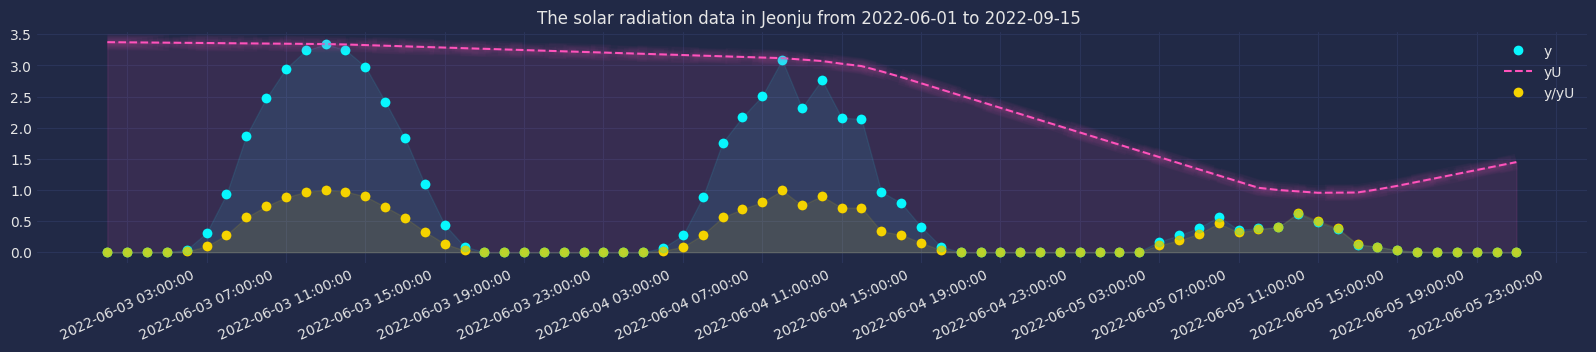

In [5]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)
t = df.loc[:,'date']
regions = list(df.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)

# plot rawdata 
start = 50 
end = 50+24*3
city = 19 # 광주 
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'o',label='y')
    plt.plot(t[start:end],yU[start:end,city],'--',label='yU')
    plt.plot(t[start:end],yP[start:end,city],'o',label='y/yU')
    tick_interval = 4
    plt.xticks(range(1, len(t) + 1, tick_interval),rotation=25)        
    plt.legend()
    plt.title("The solar radiation data in {} from {} to {} ".format(regions[city],t.to_list()[0][:10],t.to_list()[-1][:10]))
    mplcyberpunk.add_glow_effects()    

# Learn

`-` y $\to$ yhat

In [216]:
LEN_TEST

In [217]:
LEN_TR

In [235]:
# hyper params
LAGS = 4
FILTERS = 8
EPOCH = 5

# global params
TRAIN_RATIO = 0.8
T,N = len(t),len(regions) 
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

# 방법1
yhat = rgcn(y,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
yUhat = rgcn(yU,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)

yPhat = rgcn(yP,train_ratio = TRAIN_RATIO, lags=LAGS,filters=FILTERS,epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

5/5
total_mse(classic): 0.0619
total_mse(proposed): 0.0576



total_mse(classic): 0.0619
total_mse(proposed): 0.0576


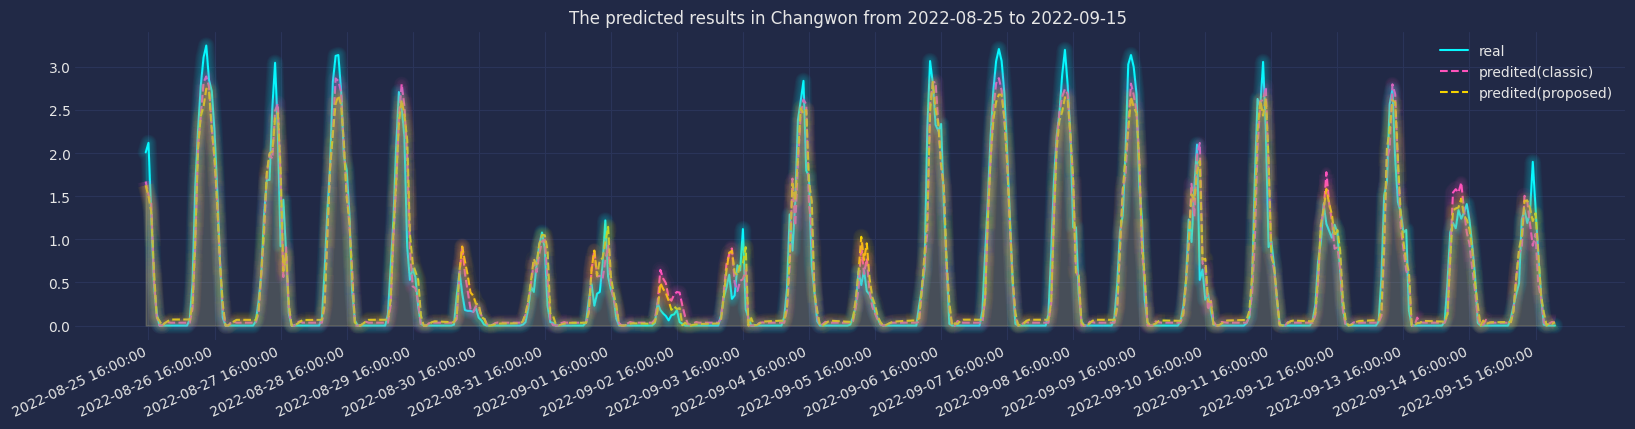

In [236]:
# plot 
start = LEN_TR 
end = LEN_TR + LEN_TEST 
city = 20
tick_interval = 24 

classic = (y - yhat)[start:end, :] ** 2
proposed = (y - yUhat*yPhat)[start:end, :] ** 2

print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 4]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'-',label='real')
    plt.plot(t[start:end],yhat[start:end,city],'--',label='predited(classic)')
    plt.plot(t[start:end],(yUhat*yPhat)[start:end,city],'--',label='predited(proposed)')
    plt.xticks(range(1, len(t[start:end]) + 1, tick_interval),rotation=25,ha='right')
    plt.title("The predicted results in {} from {} to {} ".format(regions[city],t[start:end].to_list()[0][:10],t[start:end].to_list()[-1][:10]))    
    plt.legend()
    mplcyberpunk.add_glow_effects()

# Analyze

`-` y vs yhat

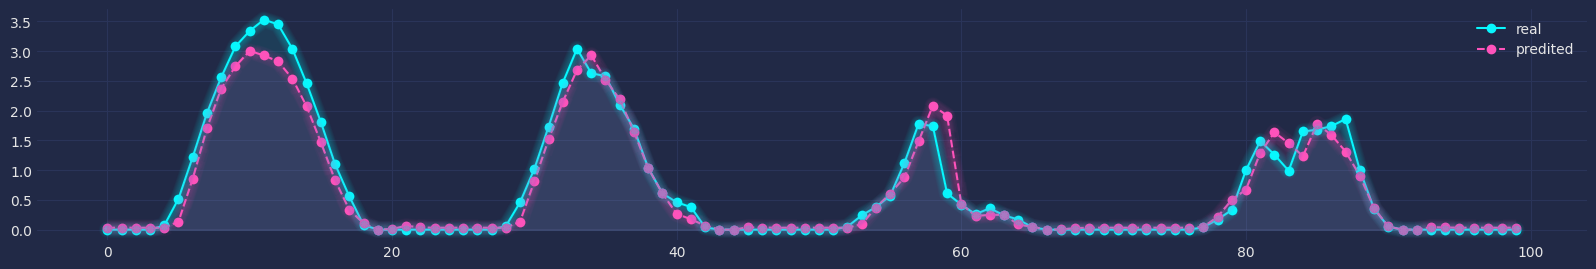

In [237]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` yU vs yUhat

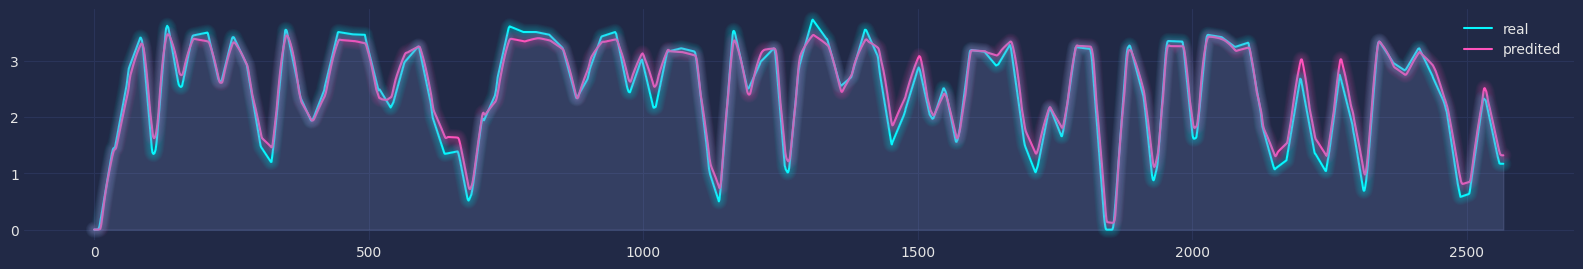

In [238]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` yP vs yPhat

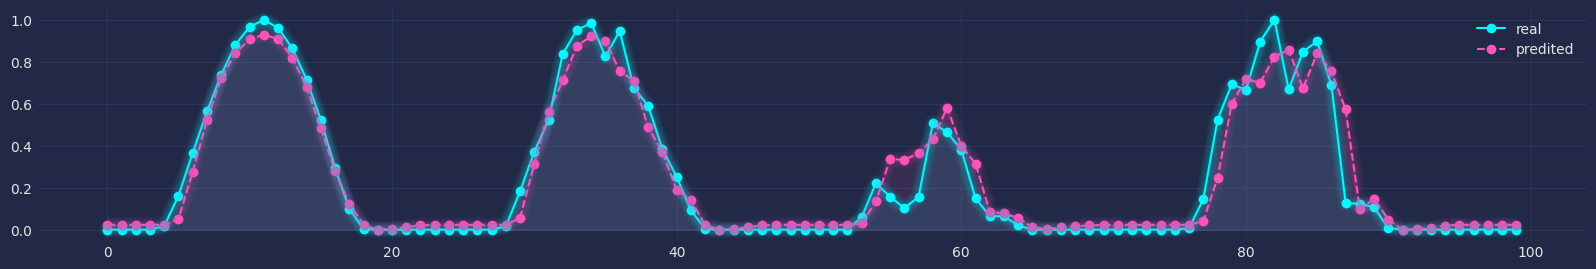

In [239]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

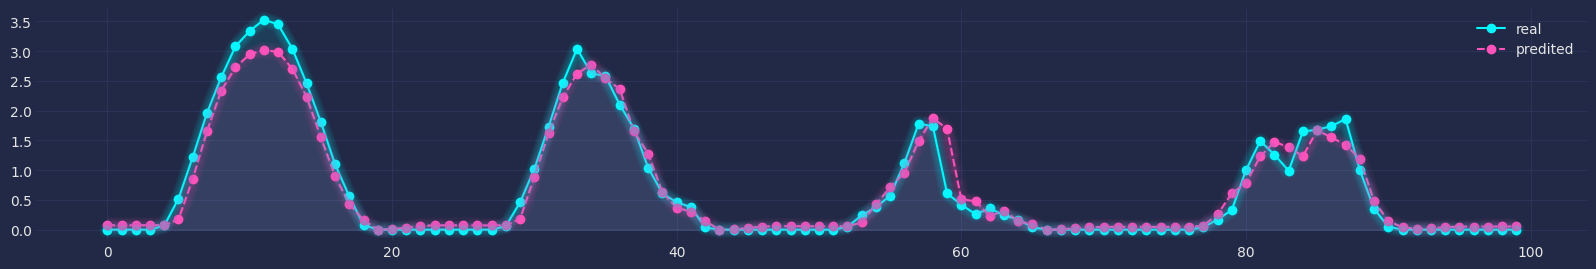

In [240]:
with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((yUhat*yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

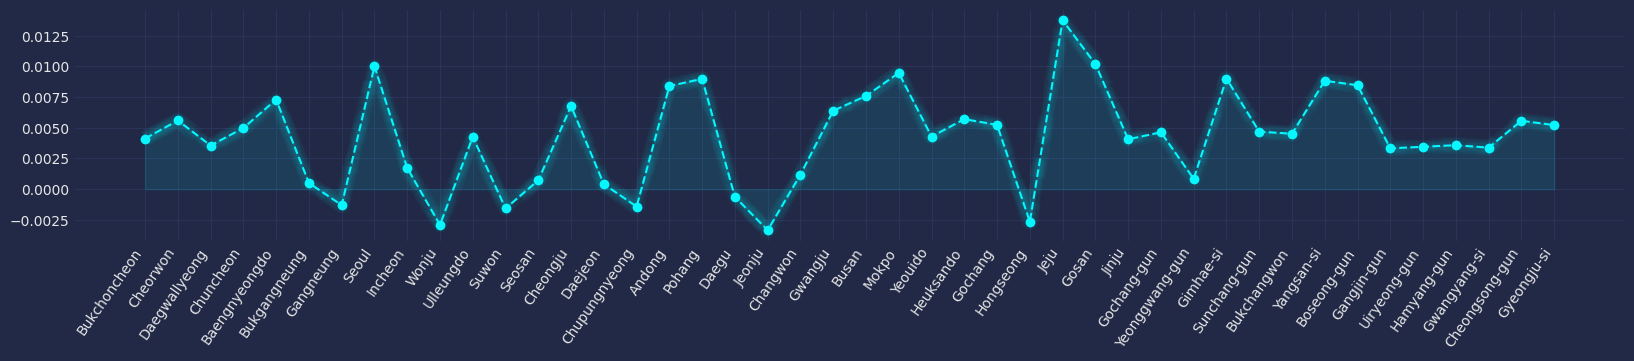

In [241]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,classic.mean(axis=0)-proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    